In [6]:
import warnings
warnings.filterwarnings("ignore")
from custom_libs import db
from custom_libs import preprocessing
from custom_libs import classification
from custom_libs import plotting
from custom_libs import best_restaurants
from custom_libs import dump

In [7]:
text_column_name = 'review'
cleaned_text_column_name = 'review_cleaned'

In [4]:
df = db.get_dataset("McDonald_s_Reviews")
preprocessing.add_id_column(df, columns=["latitude", "longitude"])
preprocessing.add_rating_number_column(df)
proprocessing_function = preprocessing.preprocess_text
preprocessing.preprocess_dataframe(df, text_column_name, cleaned_text_column_name, proprocessing_function)
df.head(2)

Number of unique ids:  40


reviewer_id  store_name              category  \
0            1  McDonald's  Fast food restaurant   
1            2  McDonald's  Fast food restaurant   

                                       store_address   latitude  longitude  \
0  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97.792874   
1  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97.792874   

  rating_count   review_time  \
0        1,240  3 months ago   
1        1,240    5 days ago   

                                              review   rating  rating_number  \
0  Why does it look like someone spit on my food?...   1 star              1   
1  It'd McDonalds. It is what it is as far as the...  4 stars              4   

   id                                     review_cleaned  
0   9  look like someone spit food normal transaction...  
1   9  far food atmosphere go staff make difference f...

In [8]:
sentiment_our_column_name = 'sentiment_our'
sentiment_auto_column_name = 'sentiment_auto'

In [9]:
# Our model
model = dump.load_model("model_chat")
vectorizer = dump.load_model("vectorizer_chat")
df[sentiment_our_column_name] = model.predict(vectorizer.transform(df[cleaned_text_column_name]))

# SentimentIntensityAnalyzer model
classification.append_sentiment_for_each_row(df, cleaned_text_column_name, new_column_name=sentiment_auto_column_name)

# Results
df[[cleaned_text_column_name, sentiment_auto_column_name, sentiment_our_column_name]]

Loading model from: dump_models/model_chat.pkl
Loading model from: dump_models/vectorizer_chat.pkl


review_cleaned sentiment_auto  \
0      look like someone spit food normal transaction...       Positive   
1      far food atmosphere go staff make difference f...       Positive   
2      make mobile order get speaker checked line mov...       Negative   
3      mc crispy chicken sandwich customer service qu...        Neutral   
4      repeat order time drive thru still manage mess...       Negative   
...                                                  ...            ...   
33391                                        treat badly       Negative   
33392                                       service good       Positive   
33393                               remove hunger enough       Negative   
33394                       good lately become expensive       Positive   
33395                                     take good care       Positive   

      sentiment_our  
0           Neutral  
1          Positive  
2          Negative  
3          Positive  
4           Neutral  
...             ...  
33391       Neutral  
33392       Neutral  
33393       Neutral  
33394       Neutral  
33395       Neutral  

[33396 rows x 3 columns]

In [10]:
# Rows with different sentiment
df_differences = df[df[sentiment_our_column_name] != df[sentiment_auto_column_name]]
df_differences.shape

(14652, 15)

In [11]:
df_differences = df_differences[[text_column_name, sentiment_auto_column_name, sentiment_our_column_name]]
db.save_dataset(df_differences, "McDonald_s_Reviews_differences")
df_differences.sample(20)

review sentiment_auto  \
7350        It's as if I was at HOME..\nVery pleasant...       Positive   
25777  Food was nice and Hot and very Tasty.FRESH ï¿½...       Positive   
21394  Staff is untrained and manager does not get in...       Negative   
25741  Very crappy place they have me waiting 15 minu...       Negative   
6026   MacDonald's restaurant is pretty much the same...       Positive   
5998   It's a sad state of affairs when you buy an ic...       Positive   
9068   Typical McDonald's. The food was good and the ...       Positive   
26132  As far as McDonald's goes this particular one ...       Positive   
5546                                               Good        Positive   
10373  Perfect for when you need a quick bite in betw...       Positive   
25398  This McDonald's is right by my house and reall...        Neutral   
21409  Wish my food would have been a lil hotter and ...       Positive   
4645                                   Courteous serverd       Positive   
854    Usually always good but today was a lil differ...       Positive   
15719  Went to order a shake at this location they sa...       Negative   
33388                       All very good food attention       Positive   
5529                                        Decent place        Neutral   
21393  Night staff doesnï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿...       Positive   
4138   Wonderful experience. Savory breakfast sandwic...       Positive   
13611  This being billed as the largest McDonalds in ...       Positive   

      sentiment_our  
7350        Neutral  
25777       Neutral  
21394      Positive  
25741      Positive  
6026       Negative  
5998       Negative  
9068        Neutral  
26132       Neutral  
5546        Neutral  
10373       Neutral  
25398      Positive  
21409       Neutral  
4645        Neutral  
854        Negative  
15719       Neutral  
33388       Neutral  
5529       Positive  
21393       Neutral  
4138        Neutral  
13611      Negative

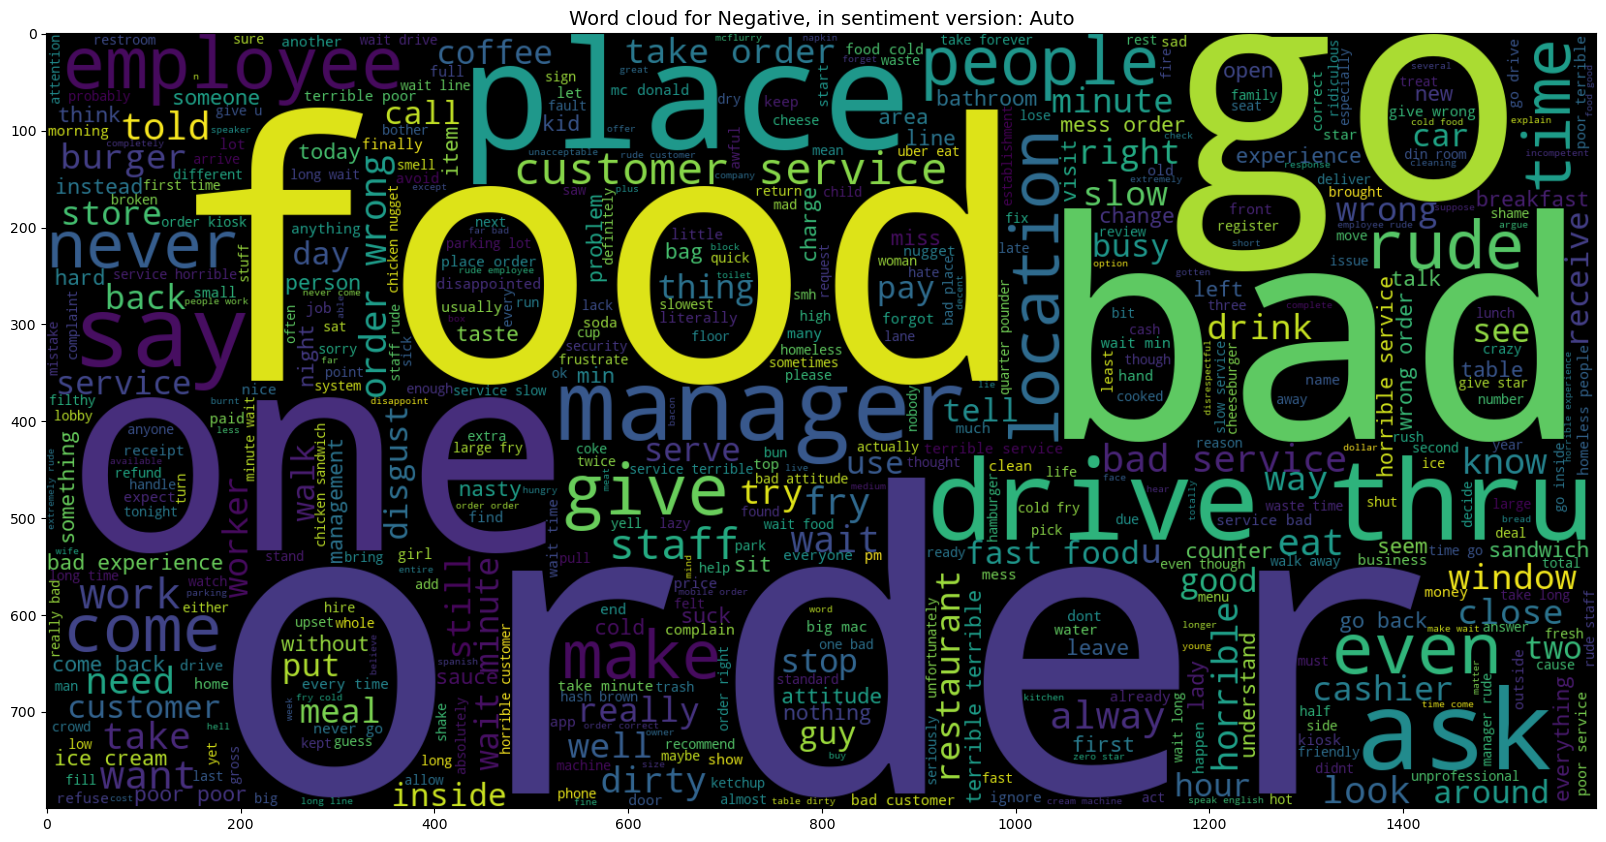

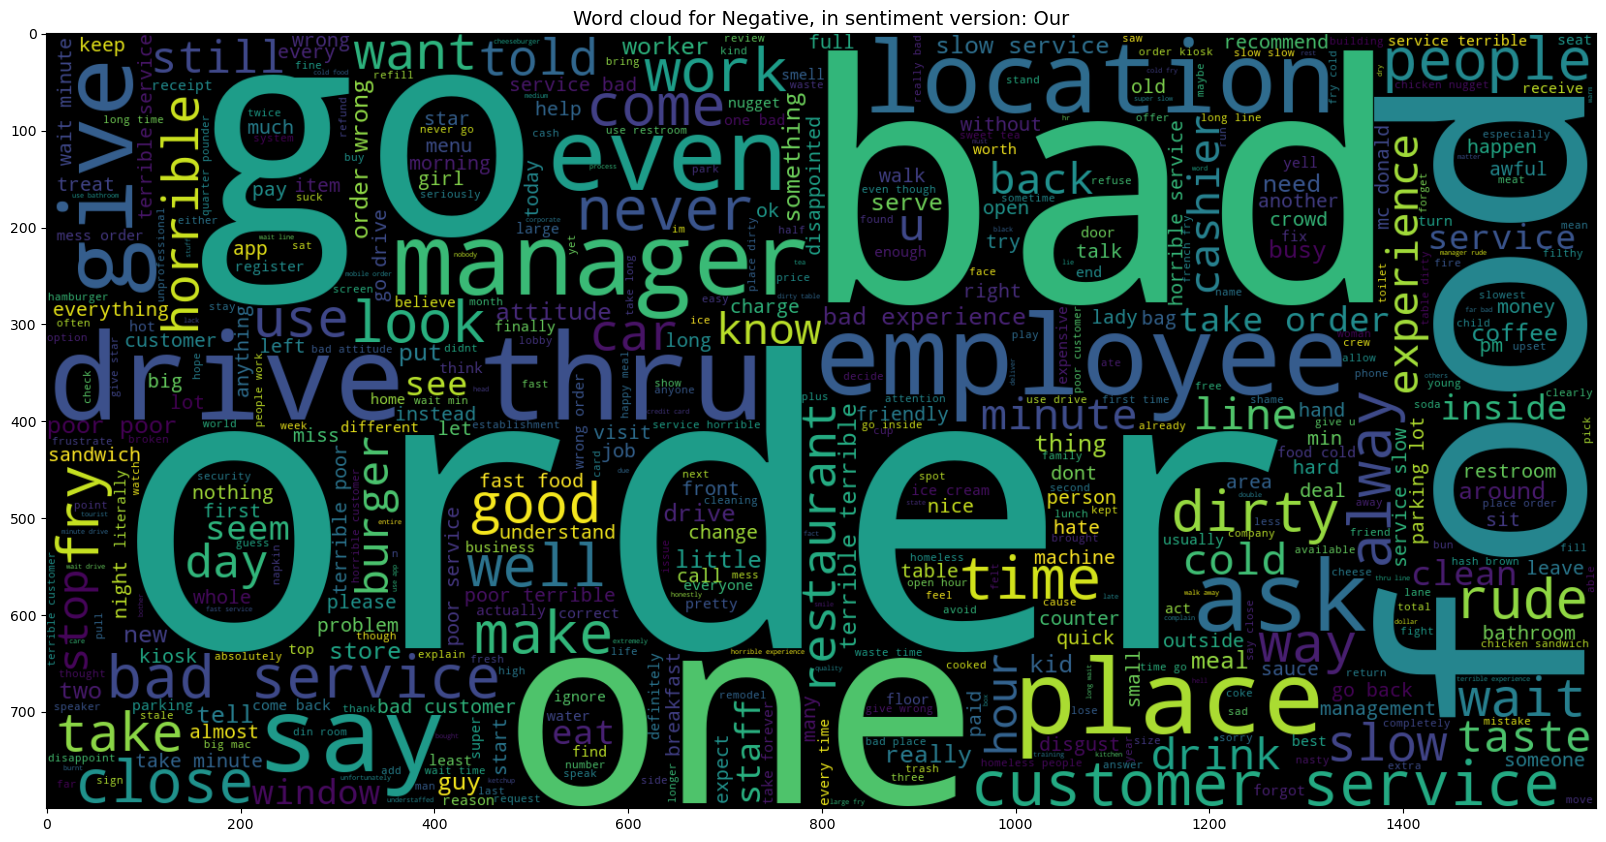

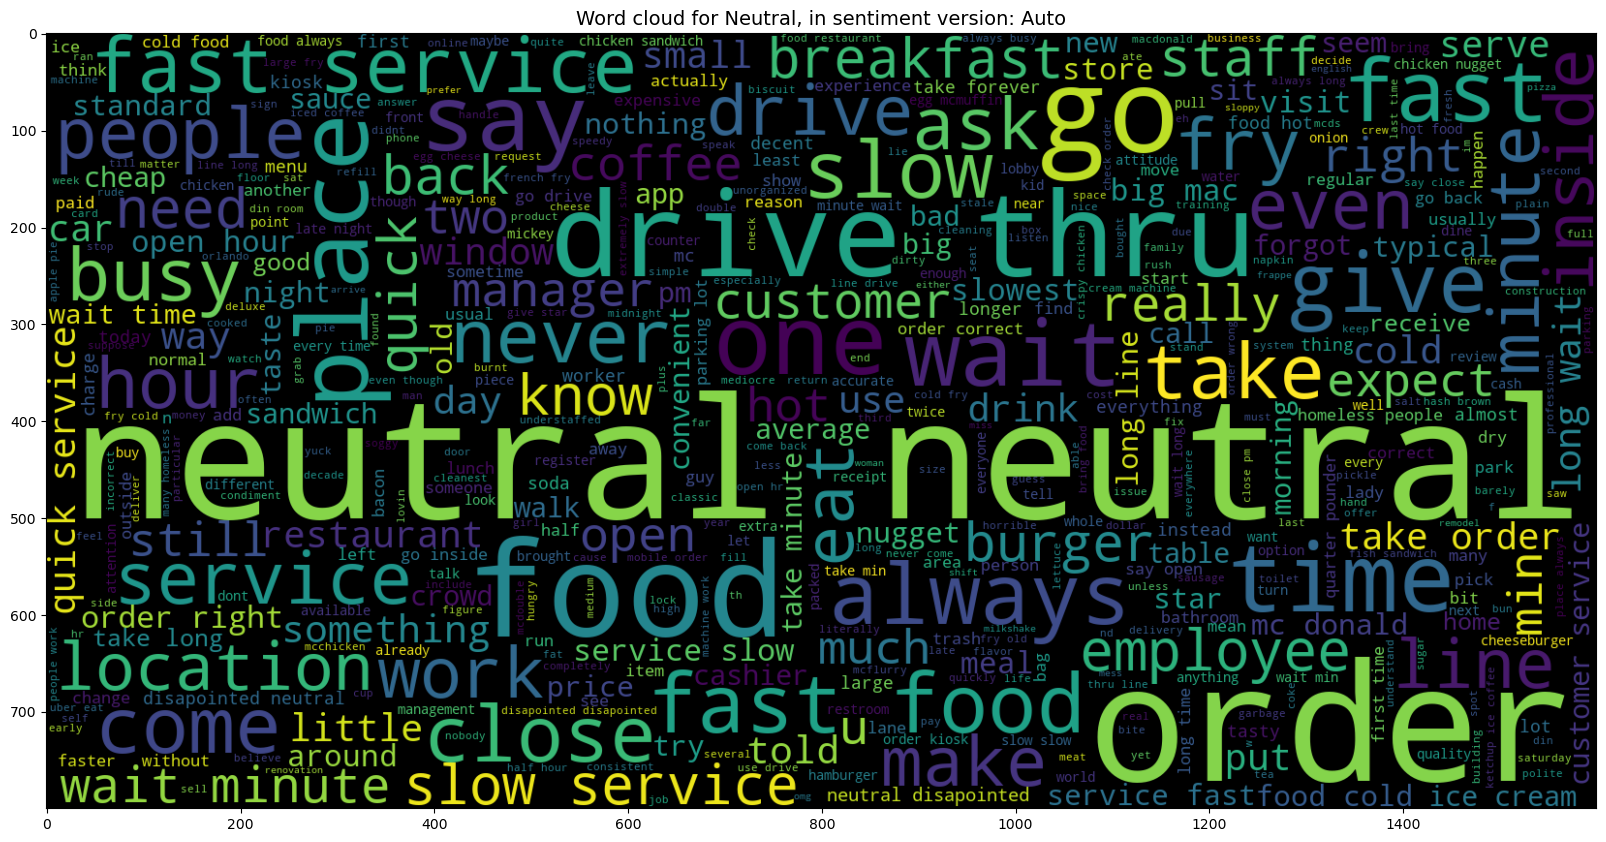

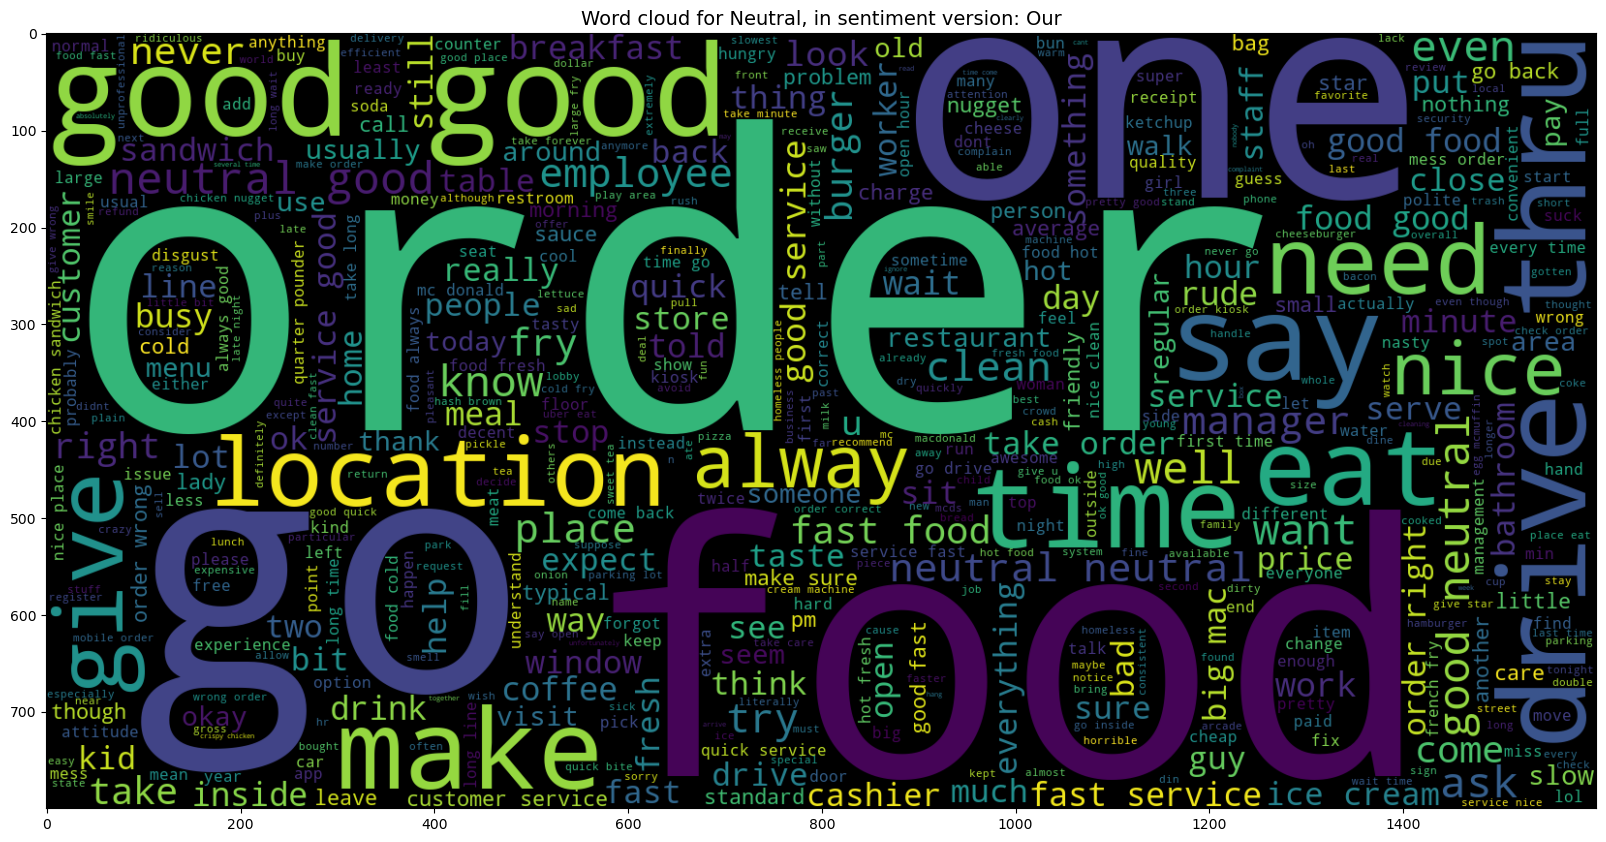

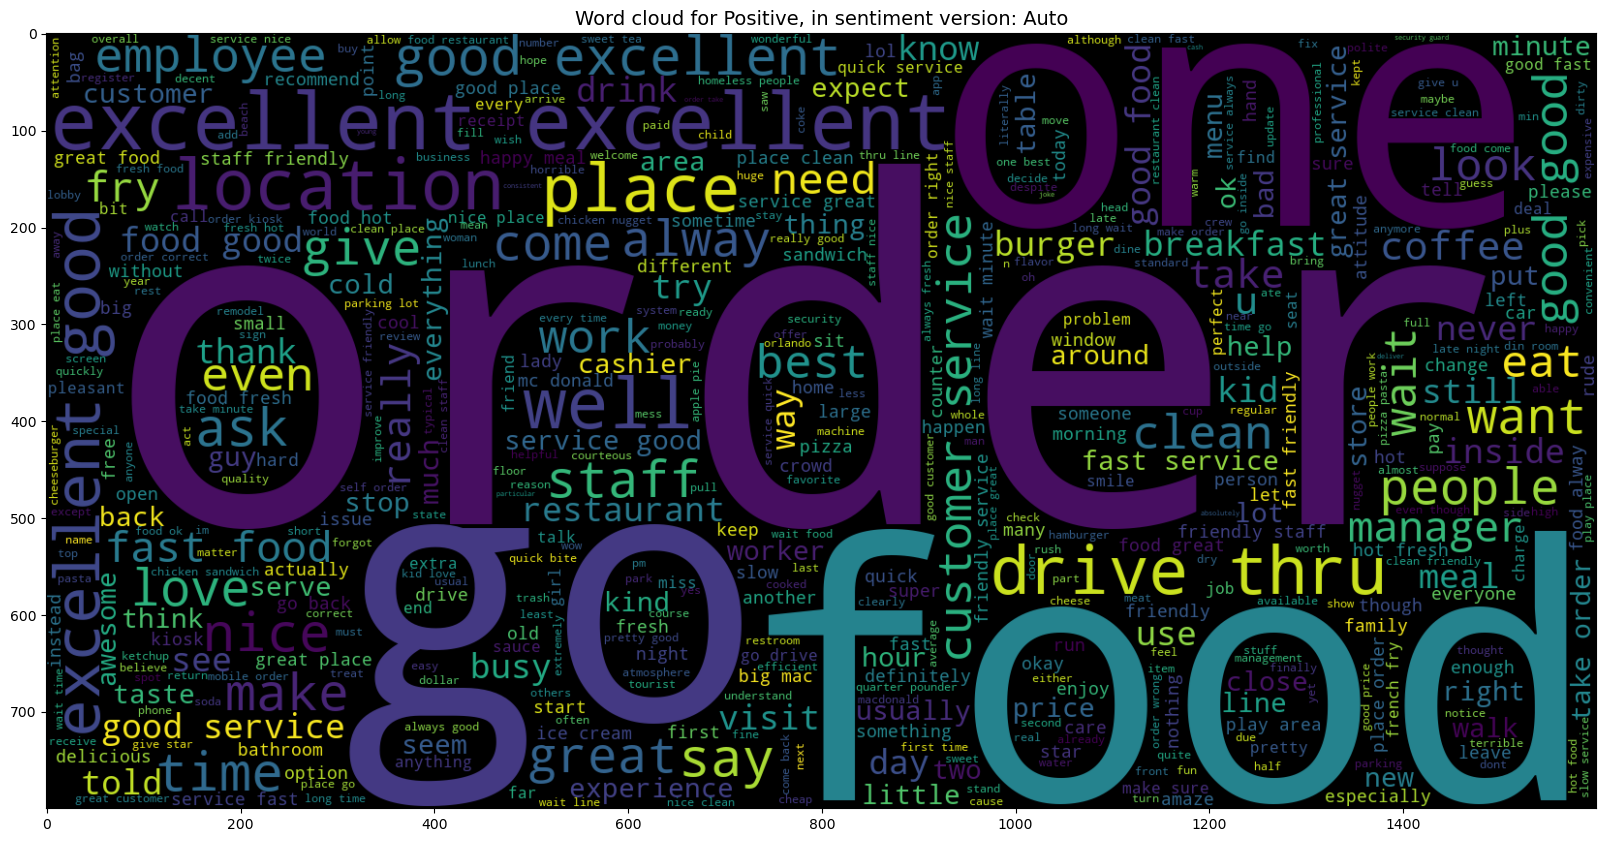

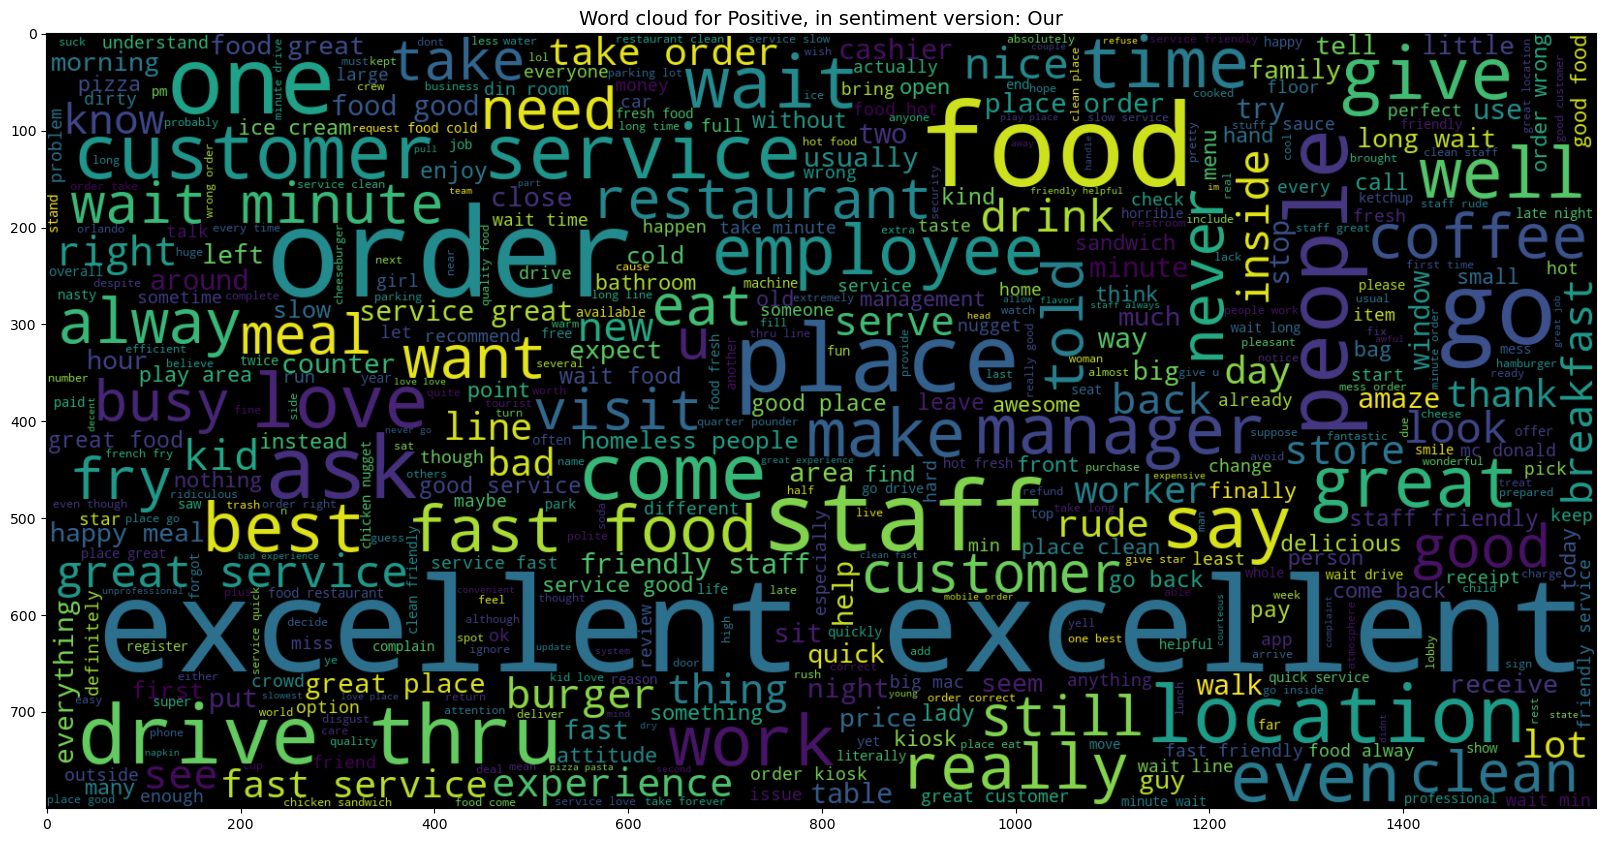

In [12]:
def plot_sentiment_word_clouds(df):
    for sentiment in classification.Sentiment.get_all():
        df_sentiment = df[(df[sentiment_auto_column_name]==sentiment)]
        plotting.plot_word_cloud(df_sentiment, sentiment, cleaned_text_column_name, plt_name="Auto")
        df_sentiment = df[(df[sentiment_our_column_name]==sentiment)]
        plotting.plot_word_cloud(df_sentiment, sentiment, cleaned_text_column_name, plt_name="Our")

plot_sentiment_word_clouds(df)

In [10]:
current_position = [30.460718, -97.792874]
max_distance = 20
best_rated_restaurant = best_restaurants.select_best_restaurant_from_stars(df, current_position, max_distance)
best_rated_restaurant

store_address   latitude  longitude
id                                                                    
8   8500 US-290, Austin, TX 78724, United States  30.329135 -97.660629

In [11]:
best_clf_column = sentiment_auto_column_name
best_feeling_restaurant = best_restaurants.select_best_restaurant_from_sentiment(df, current_position, max_distance, sentiment_column=best_clf_column)
best_feeling_restaurant

store_address   latitude  longitude
id                                                                         
9   13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97.792874